# Assignment #4: Linear Models and Decision Trees
## Foundations of Machine Learning
## Do Q1 and one other question.
### Advice: Reuse your code and code from lectures, package routine tasks into functions, make plans about how you'll carry out the analysis before jumping into writing code, and work as efficiently as possible

**Q1.** This question is a case study for linear models and decision trees. The data are about car prices. In particular, they include:

  - `Price`, `Color`, `Seating_Capacity`
  - `Body_Type`: crossover, hatchback, muv, sedan, suv 
  - `Make`, `Make_Year`: The brand of car and year produced
  - `Mileage_Run`: The number of miles on the odometer
  - `Fuel_Type`: Diesel or gasoline/petrol
  - `Transmission`, `Transmission_Type`:  speeds and automatic/manual

  1. Load `cars_hw.csv`. These data were really dirty, and I've already cleaned them a significant amount in terms of missing values and other issues, but some issues remain (e.g. outliers, badly scaled variables that require a log or arcsinh transformation). Clean the data however you think is most appropriate.
  2. Summarize the `Price` variable and create a kernel density plot. Use `.groupby()` and `.describe()` to summarize prices by brand (`Make`). Make a grouped kernel density plot by `Make`. Which car brands are the most expensive? What do prices look like in general?
  3. Split the data into an 80% training set and a 20% testing set.
  4. Let's focus on linear models. Make a model where you regress price on the numeric variables alone; what is the $R^2$ and `RMSE` on the test set? Make a second model where, for the categorical variables, make a model comprised of one-hot encoded regressors/features alone, and regress price on those variables; what is the $R^2$ and `RMSE` on the test set? Which model performs better on the test set? Make a third model that combines all the regressors from the previous two; what is the $R^2$ and `RMSE` on the test set? Does the joint model perform better or worse, and by home much?
  5. Use the `PolynomialFeatures` function from `sklearn` to expand the set of numerical variables you're using, along with the categorical variables. As you increase the degree of the expansion, how do the $R^2$ and `RMSE` change? At what point does $R^2$ go negative on the test set? For your best model with expanded features, what is the $R^2$ and `RMSE`? How does it compare to your best model from part 3?
  6. For your best model so far, determine the predicted values for the test data and plot them against the true values. Do the predicted values and true values roughly line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero? Evaluate the strengths and weaknesses of your model.
  7. Now, let's use a regression tree. Construct an appropriate matrix of regressors/features, and fit a tree to the data. Vary the maximum depth of the decision tree using the `max_depth` option (i.e. `tree.DecisionTreeRegressor(max_depth=D)`), and compute the $R^2$ and `RMSE` on the test set of a variety of depths. What depth tree gives the best results?
  8. For your best tree, determine the predicted values for the test data, and plot them against the true values. Do the predicted values and true values line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero?
  12. Which model --- linear model or classification and regression tree --- has better performance on the test set?

In [58]:
import numpy as np
import pandas as pd
import seaborn as sns
import math

In [59]:
#1
df = pd.read_csv("data/cars_hw.csv")

<Axes: >

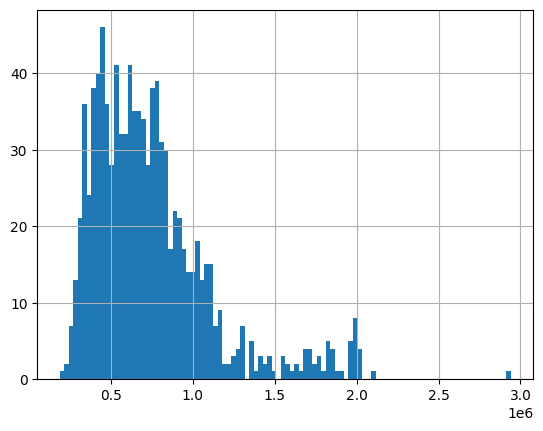

In [60]:
df["Price"].hist(bins = 100)

<Axes: >

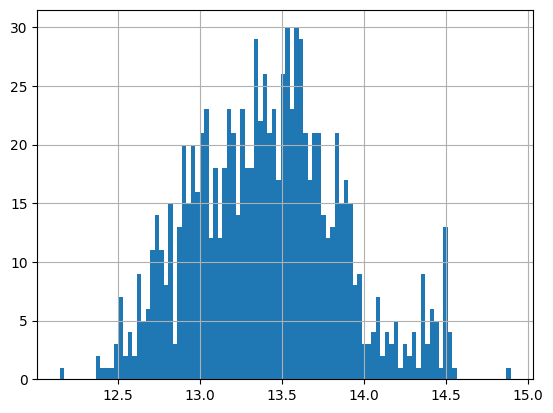

In [61]:
df["lprice"]=np.log(df["Price"])
df["lprice"].hist(bins = 100)

<Axes: >

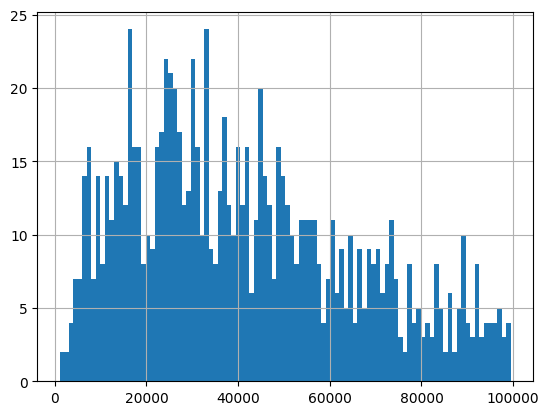

In [62]:
df["Mileage_Run"].hist(bins = 100)

<Axes: >

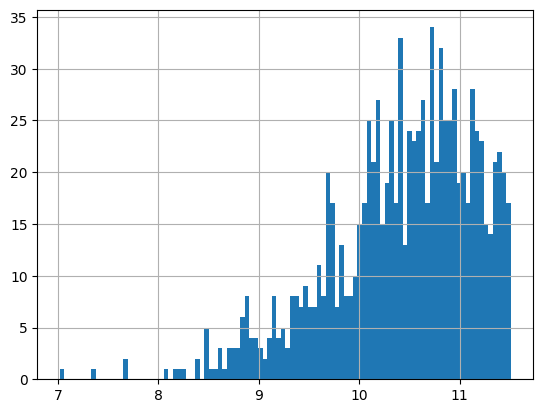

In [63]:
df["lmiles"]=np.log(df["Mileage_Run"])
df["lmiles"].hist(bins = 100)

<Axes: >

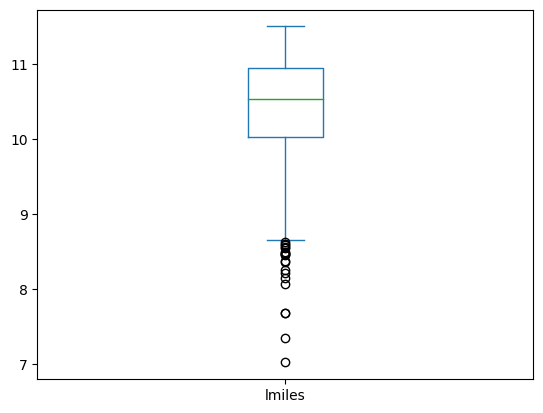

In [64]:
df['lmiles'].plot.box()

In [65]:
df = df.loc[df['lmiles']>8.2,:]

In [66]:
df['age'] = max(df['Make_Year'])-df['Make_Year']

In [67]:
df["No_of_Owners"].value_counts()# Consider this practically a new vs used variable 

1st    812
2nd    154
3rd      4
Name: No_of_Owners, dtype: int64

In [68]:
df["used"]=df["No_of_Owners"]
df["used"]=df["used"].replace("1st",0)
df["used"]=df["used"].replace("2nd",1)
df["used"]=df["used"].replace("3rd",1)
df["used"].value_counts()

0    812
1    158
Name: used, dtype: int64

In [69]:
#df["Fuel_Type"].value_counts()#make it diesel or no
df["diesel"]=df["Fuel_Type"].replace("diesel",1)
df["diesel"]=df["diesel"].replace("petrol",0)
df["diesel"]=df["diesel"].replace("petrol+cng",0)
df["diesel"].value_counts()

0    779
1    191
Name: diesel, dtype: int64

In [70]:
df["Transmission_Type"].value_counts()
df["automatic"]=df["Transmission_Type"].replace("Automatic",1)
df["automatic"]=df["automatic"].replace("Manual",0)

In [71]:
df["Transmission"].value_counts()
df['5speed']=0
df['7speed']=0
df['6speed']=0
df['4speed']=0
df['cvt']=0
df.loc[ df["Transmission"]=="5-Speed","5speed"]=1
df.loc[ df["Transmission"]=="6-Speed","6speed"]=1
df.loc[ df["Transmission"]=="4-Speed","4speed"]=1
df.loc[ df["Transmission"]=="7-Speed","7speed"]=1
df.loc[ df["Transmission"]=="CVT","cvt"]=1


In [72]:
df.head()

,Unnamed: 0,Make,Make_Year,Color,Body_Type,Mileage_Run,No_of_Owners,Seating_Capacity,Fuel_Type,Transmission,...,lmiles,age,used,diesel,automatic,5speed,7speed,6speed,4speed,cvt
0,1,Volkswagen,2017,silver,sedan,44611,1st,5,diesel,7-Speed,...,10.705736,5,0,1,1,0,1,0,0,0
1,2,Hyundai,2016,red,crossover,20305,1st,5,petrol,5-Speed,...,9.918622,6,0,0,0,1,0,0,0,0
2,3,Honda,2019,white,suv,29540,2nd,5,petrol,5-Speed,...,10.293501,3,1,0,0,1,0,0,0,0
3,4,Renault,2017,bronze,hatchback,35680,1st,5,petrol,5-Speed,...,10.482346,5,0,0,0,1,0,0,0,0
4,5,Hyundai,2017,orange,hatchback,25126,1st,5,petrol,5-Speed,...,10.131658,5,0,0,0,1,0,0,0,0


In [73]:
#2
df.groupby("Make")["lprice"].describe()

,count,mean,std,min,25%,50%,75%,max
Make,,,,,,,,
Chevrolet,6.0,12.919895,0.480975,12.495004,12.568392,12.752286,13.171681,13.701221
Datsun,3.0,12.576047,0.036311,12.538967,12.558302,12.577636,12.594587,12.611538
Ford,52.0,13.468280,0.210895,12.577636,13.361380,13.469493,13.575984,13.879424
Honda,73.0,13.536318,0.336972,12.663497,13.272506,13.573439,13.726679,14.245343
Hyundai,304.0,13.368167,0.399394,12.421184,13.091388,13.366094,13.639365,14.370544
Jeep,4.0,14.216591,0.105084,14.070153,14.183270,14.240265,14.273586,14.315680
Kia,8.0,14.292177,0.076877,14.129591,14.272242,14.303105,14.349515,14.369970
MG Motors,35.0,14.439052,0.066263,14.278615,14.395744,14.429615,14.497597,14.518113
Mahindra,18.0,13.898953,0.159906,13.587354,13.851808,13.905680,13.961249,14.197366


<Axes: xlabel='lprice', ylabel='Density'>

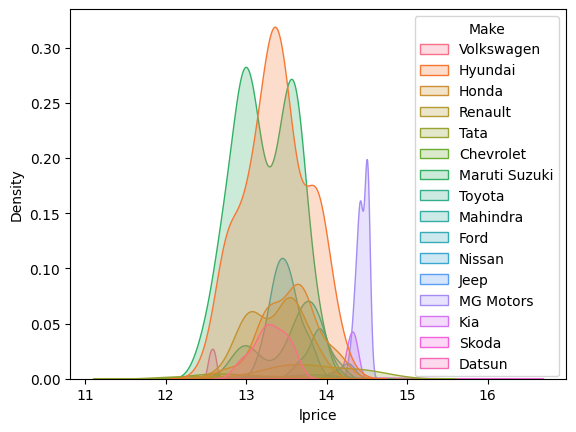

In [74]:
sns.kdeplot(data=df,x="lprice",hue="Make",fill=True)

The grouped kernel density plot shows that car brands MG Motors and KIA appear to be the most expensive. In general the graph shows a very interesting trend of market dominators Honda and Toyota trading off price groups, with Toyota holding low and high price brakcets and honda dominating middle market. This is an intersting pricing tactic between these two massive manufacturers. 

In [75]:
#3
y = df['lprice'] # Create target variable vector
X = df.drop(["Price","lprice"], axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=100)

In [76]:
#4
from sklearn.linear_model import LinearRegression # Import linear regression model
from sklearn.metrics import mean_squared_error

vars = ['Mileage_Run','Seating_Capacity','lmiles','age'] # This is a list of variables to use

X1 = X_train.loc[:,vars] # Construct data matrix
print(X1.head()) # Peek at data

def linear(X,y,print):
    if print:
        print("Intercept: " + str(reg.intercept_)) # Intercept value
        print("Coefficients: " + str(reg.coef_)) # Regression coefficients
        print("R squared: " + str(reg.score(X, y)))# R squared measure
        print("SSE: " + str(np.sum( (y-reg.predict(X))**2) ))
        print("RMSE: " + str(mean_squared_error(y,reg.predict(X),squared=False)))#RMSE
    return(reg.score(X, y))
X1_test=X_test.loc[:,vars]
reg = LinearRegression().fit(X1, y_train)
linear(X1_test,y_test,print)

     Mileage_Run  Seating_Capacity     lmiles  age
209        59054                 5  10.986208    9
188        93446                 5  11.445139    6
106        68269                 5  11.131211    8
103        72356                 5  11.189354    9
542        12256                 7   9.413771    2
Intercept: 11.888651133065457
Coefficients: [ 8.84365950e-08  9.44433714e-02  1.60486065e-01 -1.24470683e-01]
R squared: 0.31680223265264396
SSE: 24.566727302157897
RMSE: 0.3558547666669322


0.31680223265264396

In [77]:
vars = ['used','diesel','automatic','7speed','5speed','4speed','6speed'] # This is a list of variables to use
print(X1.head()) # Peek at data
X1 = X_train.loc[:,vars] # Construct data matrix


     Mileage_Run  Seating_Capacity     lmiles  age
209        59054                 5  10.986208    9
188        93446                 5  11.445139    6
106        68269                 5  11.131211    8
103        72356                 5  11.189354    9
542        12256                 7   9.413771    2


In [78]:
vars=['used','diesel','automatic','7speed','5speed','4speed','6speed','Mileage_Run','Seating_Capacity','lmiles','age']
X1 = X_train.loc[:,vars] # Construct data matrix
X1_test=X_test.loc[:,vars]
reg = LinearRegression().fit(X1, y_train)
linear(X1_test,y_test,print)

Intercept: 12.66154330533047
Coefficients: [-2.89066694e-02  2.63106377e-01  8.45640467e-02  3.28791961e-01
 -1.53935841e-01 -9.66425659e-02  2.36041769e-01 -1.76937107e-06
  4.33595440e-02  1.03663598e-01 -9.23824410e-02]
R squared: 0.5764133199596991
SSE: 15.231517072692249
RMSE: 0.2802016677350555


0.5764133199596991

Question 4. 

When comparing these models we see that R squared was the best for the combined model, then numeric, then categorical. First we must understand that R sqaured in its unadjusted form will favor more variables, thus it is difficult to compare especially between 1 or 2 and 3. This being said taken literally R squared states that model 3 has the most explanatory power on lprice. Between 1 and 2, R sqaured shows that 2 has more explantory power. This means that the categorical variables in model 2 could be more important in understanding what impacts price. When looking at RMSE model 3 once again does best, coming in at lowest score. The same is true for 1 and 2 where model 1 once again shows lower error meaning a greater fit. Thus model 3 performs far better on R squared which could be influenced but also wins on the more standardized RMSE metric. 

In [79]:
#5
from sklearn.preprocessing import PolynomialFeatures

catvars=['used','diesel','automatic','7speed','5speed','4speed','6speed']
cat=X_train.loc[:,catvars]
i=0
def test(i=0):
    vars = ['Mileage_Run','Seating_Capacity','lmiles','age']
    Xpoly = X_train.loc[:,vars]
    indexes=Xpoly.index
    expander = PolynomialFeatures(degree=i+1,include_bias=False) # Create the expander
    X = expander.fit_transform(Xpoly) # Pass the df into the expander to get powers/interactions of x and y
    names = expander.get_feature_names_out() # Get the names of these variables
    Xpoly=pd.DataFrame(data=X,columns=names,index=indexes)
    Xpoly=Xpoly.join(cat)
    r2=linear(Xpoly,y_train,print=False)
    #print("i: "+str(i))
    #print(r2)
    rsquared.append(r2)
    rsquared =[] 
#while r2 >0:
 #   Xpoly=0
  #  test(i)
   # i+=1
#using this method it is clear that best occurs at i=1/degree=2. negative will be determined using same method but testing values.
#test(60) r2 = .027990898383342455
#test(70) overflow - warning

From the code written above it is impossible to get R2 to go negative. Overflow warning appears at about i=70 when R2 is still approximately .02. Upon review of the code, I am unaware of any clear errors. This may be because of the normalization of price to lprice creating a better fit model. 

In [83]:
#best outcome from #5, degree=2
catvars=['used','diesel','automatic','7speed','5speed','4speed','6speed']
cat=X_train.loc[:,catvars]
vars = ['Mileage_Run','Seating_Capacity','lmiles','age']
Xpoly = X_train.loc[:,vars]
indexes=Xpoly.index
expander = PolynomialFeatures(degree=2,include_bias=False) # Create the expander
X = expander.fit_transform(Xpoly) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
Xpoly=pd.DataFrame(data=X,columns=names,index=indexes)
Xpoly=Xpoly.join(cat)
reg = LinearRegression().fit(Xpoly, y_train)

catvars=['used','diesel','automatic','7speed','5speed','4speed','6speed']
cat=X_test.loc[:,catvars]
vars = ['Mileage_Run','Seating_Capacity','lmiles','age']
Xpoly_test = X_test.loc[:,vars]
indexes=Xpoly_test.index
expander = PolynomialFeatures(degree=2,include_bias=False) # Create the expander
X = expander.fit_transform(Xpoly_test) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
Xpoly_test=pd.DataFrame(data=X,columns=names,index=indexes)
Xpoly_test=Xpoly_test.join(cat)
linear(Xpoly_test,y_test,print)

Intercept: -30.259184461045262
Coefficients: [ 1.69013034e-03  2.62779785e+00  9.64877737e+00  3.50983785e-01
  5.49979209e-10 -8.63002941e-07 -1.39406016e-04  1.69388645e-06
 -2.34716291e-01  1.54089649e-02  2.77885864e-02 -6.70830999e-01
 -6.14584228e-02 -8.21499335e-04 -3.44785392e-02  2.54141411e-01
  7.72810136e-02  3.15294878e-01 -1.66981280e-01 -4.95851590e-02
  2.26517311e-01]
R squared: 0.6042938319225051
SSE: 14.228977299920174
RMSE: 0.27082327044406934


0.6042938319225051

The polynomial features imporve the R2 of the graph. Best for #3 was combined at about .57 and now we see .604 which is an imporvment. For RMSE we decrease from .28 to .27 which is also an imporvment. 

#6 For your best model so far, determine the predicted values for the test data and plot them against the true values. Do the predicted values and true values roughly line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero? Evaluate the strengths and weaknesses of your model.

In [84]:
#6
catvars=['used','diesel','automatic','7speed','5speed','4speed','6speed']
cat=X_test.loc[:,catvars]
vars = ['Mileage_Run','Seating_Capacity','lmiles','age']
Xtest2 = X_test.loc[:,vars]
indexes=Xtest2.index
expander = PolynomialFeatures(degree=2,include_bias=False) # Create the expander
X = expander.fit_transform(Xtest2) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
Xtest2=pd.DataFrame(data=X,columns=names,index=indexes)
Xtest2=Xtest2.join(cat)




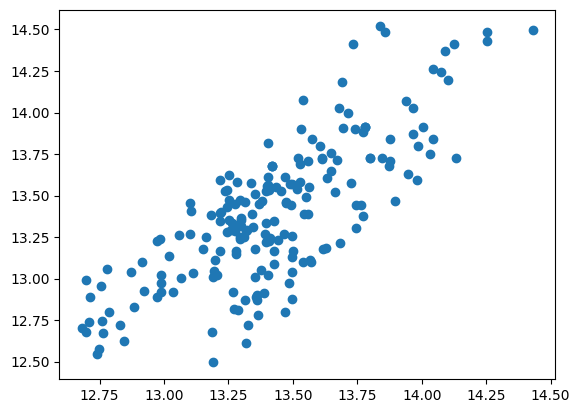

In [85]:
import matplotlib.pyplot as plt
reg = LinearRegression().fit(Xpoly,y_train) # Fit the linear model
yhat=reg.predict(Xtest2)
plt.scatter(x=yhat,y=y_test)

In [86]:
residuals = y_test-yhat

<Axes: xlabel='lprice', ylabel='Density'>

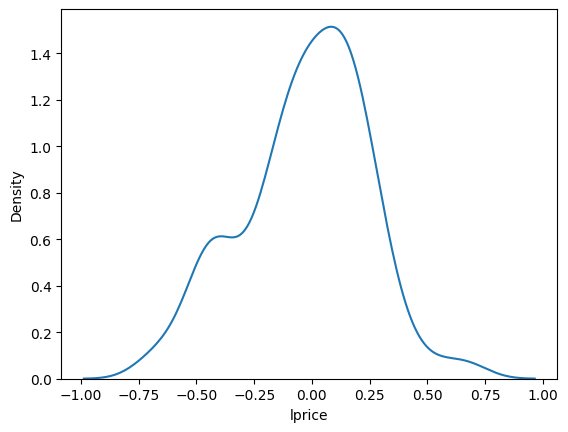

In [87]:
sns.kdeplot(data=residuals)

The model shows that it meets many of the basic requirments to be considered a good model. The predicted values and the test values do create an apparent diagnol line. Visually this supports that there is a y=x relationship and thus the predictions are doing their job. The residuals also appear roughly bell shaped. This means that they are normally distrubuted and thus expected error is approximately 0. This allows the model to be an effective prediciton tool. It is lear that the residuals are not perfectly over zero, and this means that their is bias and thus harms the effectivness of the model. 

#7 Now, let's use a regression tree. Construct an appropriate matrix of regressors/features, and fit a tree to the data. Vary the maximum depth of the decision tree using the max_depth option (i.e. tree.DecisionTreeRegressor(max_depth=D)), and compute the  𝑅2  and RMSE on the test set of a variety of depths. What depth tree gives the best results?

In [88]:
#7
import decimal
from decimal import Decimal
vars=['used','diesel','automatic','7speed','5speed','4speed','6speed','Mileage_Run','Seating_Capacity','lmiles','age']
D_X = X_train.loc[:,vars] # Construct data matrix


D_X['lmiles']=D_X['lmiles'].apply(lambda x: Decimal(str(x)))
D_X['lmiles']=D_X['lmiles'].apply(lambda x: x*100000)
D_X['lmiles']=D_X['lmiles'].astype('int64')

y_train2=y_train.apply(lambda x: Decimal(str(x)))
y_train2=y_train2.apply(lambda x: x*100000)
y_train2=y_train2.astype('int64')

y_test2=y_test.apply(lambda x: Decimal(str(x)))
y_test2=y_test2.apply(lambda x: x*100000)
y_test2=y_test2.astype('int64')
#D_X.head()

#some questionable manipulation to get around the float issues. This preserves the logarithmec transformation to 5 decimal
#places but makes the new lprice an int of magnitude 1000000.

In [89]:
from sklearn import tree # Import the tree classifier
vars=['used','diesel','automatic','7speed','5speed','4speed','6speed','Mileage_Run','Seating_Capacity','lmiles','age']
X_test3 = X_test.loc[:,vars] 

X_test3['lmiles']=X_test3['lmiles'].apply(lambda x: Decimal(str(x)))
X_test3['lmiles']=X_test3['lmiles'].apply(lambda x: x*100000)
X_test3['lmiles']=X_test3['lmiles'].astype('int64')

def regtree(D):
    cart = tree.DecisionTreeRegressor(max_depth=D) # Create a classifier object
    cart = cart.fit(D_X, y_train2) # Fit the classifier
    #Make Predictions on the Test Set
    y_hat2 = cart.predict(X_test3)
    print("----------------")
    print(D)
    print("R squared: " + str(cart.score(X_test3, y_test2)))# R squared measure
    print("RMSE: " + str(mean_squared_error(y_test,y_hat2,squared=False)))#RMSE
    print("----------------")

    

In [90]:
regtree(6)
regtree(10)
regtree(15)
regtree(3)
regtree(5)
regtree(7)

----------------
6
R squared: 0.5527469273644774
RMSE: 1342434.0257691087
----------------
----------------
10
R squared: 0.470955239263267
RMSE: 1342437.0822761245
----------------
----------------
15
R squared: 0.3859994979905057
RMSE: 1341936.0404563604
----------------
----------------
3
R squared: 0.4410999126115974
RMSE: 1343439.3102123856
----------------
----------------
5
R squared: 0.5306223822469127
RMSE: 1342046.5380993045
----------------
----------------
7
R squared: 0.5559291319751327
RMSE: 1341546.3149472661
----------------


The tree gives the best results around 6 max depth. This gives an R2 of about .553 which suggests a level of predictive ability. RMSE is still very large but this could be due to the transformation.

  8. For your best tree, determine the predicted values for the test data, and plot them against the true values. Do the predicted values and true values line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero?

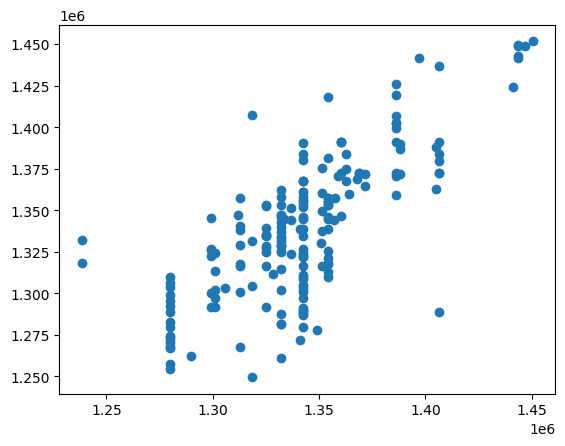

In [91]:
 # Fit the linear model
cart = tree.DecisionTreeRegressor(max_depth=6) # Create a classifier object
cart = cart.fit(D_X, y_train2) # Fit the classifier
#Make Predictions on the Test Set
y_hat2 = cart.predict(X_test3)
plt.scatter(x=y_hat2,y=y_test2)

In [92]:
residuals = y_test2-y_hat2

<Axes: xlabel='lprice', ylabel='Density'>

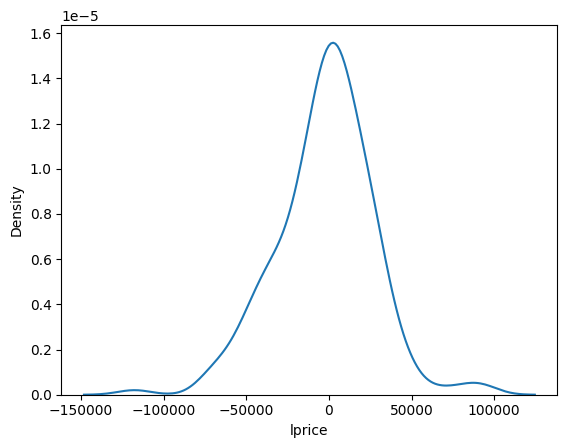

In [93]:
sns.kdeplot(data=residuals)

This shows that the model visually does appear to do its job. The relationship between yhat and ytest is roughly diaganol. It is far  tight in spread than for the linear model, however the relationship could be described as y=x. Furthermore the residuals do appear unbiased and consistent. They in fact are better alligned about 0 than for the linear model, which was sightly biased. Thus the model is probably usable even at low explanatory levels. 

9. Which model --- linear model or classification and regression tree --- has better performance on the test set?

The linear model is  superior to the tree for this problem. First  it is likely that in general linear regression is better for numeric prediction such has price. This is becasue decision trees are largely built for categorical classification, something that linear regression may not be as nuaced in deciding. For this problem linear regression  with a R2 of above .6 and a RMSE of .55. This is compared to .12 and 1300000+ RMSE. HOWEVER, it is extremely important to understand that the regression tree required serious transfomation in order to be workable. This being said it is my understanding that a linear scaling would not impact the foundations of the predicitive qualities, it could be what laed to the magnitudes larger RMSE. Overall however the linear model is better for the problem at hand.

**Q2.** 
The is a question about regression using decision trees and linear models. The data include wages at data science-y jobs, including

  - `Rating`: Company worker happiness score
  - `Size`: Number of employees
  - `Sector`: Part of the economy
  - `avg_salary`: Average wage
  - `job_state`: Location of work

  1. Load the `wages_hw.csv` file. Split the sample into an ~80% training set and a ~20% test set. Do any necessary cleaning, including outliers and missings.
  2. Use a linear model to regress `avg_salary` on `Sector`. Which sectors have the highest predicted wages? What is the $R^2$ and `RMSE` on the test set? 
  3. Make a scatterplot of `avg_salary` and `Rating`. Is there an obvious visual relationship between the two variables? Regress `avg_salary` on `Rating` as a numeric variable: Do higher ratings predict higher or lower wages? Convert `Rating` to a one-hot encoded variable, with a category for each rating. Run a regression of `avg_salary` on the categorical version. How do your results change? Explain. Which version has a higher $R^2$ and lower `RMSE`?
  4. Now interact `Sector` with the categorical version of `Rating`, so your regressors are a (Sector, Rating) pair; this is a programming puzzle you'll have to think about, but using the `.PolynomialFeatures()` function on the one-hot encoded categorical variables is one option, and another is pre-processing a new variable that interacts `Sector` and `Rating` and then one-hot encoding the result. Regress `avg_salary` on the (Sector, Rating) pairs. How does the $R^2$ and `RMSE` on the test set compare to part 2? Interpret the coefficients; which sector-rating pairs have the highest wages?
  5. Run a linear regression of `avg_salary` on all the variables. What is the $R^2$ on the test set? How does it compare to your simpler models in 2--4? 
  6. Build a decision tree by regressing `avg_salary` on `Sector`, `Rating`, and the (Sector, Rating) pairs. What are the $R^2$ and `RMSE` of your models on the test set? How do your answers compare to parts 2, 3, and 4?
  7. Build a decision tree by regressing `avg_salary` on all the other variables. What is the $R^2$ and `RMSE` on the test set?
  8. Build a linear regression or decision tree using the available variables based on your own judgment. What degrees of freedom are you giving the model to predict variation in wages across company and location attributes? What is the $R^2$ and `RMSE` of your model? How does it compare to the previous ones in the question? Why does yours perform better or worse on the test set?

**Q3.** This a question purely on categorical prediction. The data for this happen to be gathered in 1987 in Indonesia, and concern contraceptive method choice. The questions and data-gathering assumptions reflect the culture and attitudes of that time and place, but provide a good example of a categorical prediction problem on an important topic (family planning and maternal health The variables in the data are:

    - Wife's age (numerical)
    - Wife's education (categorical) 1=low, 2, 3, 4=high 
    - Husband's education (categorical) 1=low, 2, 3, 4=high 
    - Number of children ever born (numerical) 
    - Wife's religion (binary) 0=Non-Islam, 1=Islam
    - Wife's now working? (binary) 0=Yes, 1=No
    - Husband's occupation (categorical) 1, 2, 3, 4
    - Standard-of-living index (categorical) 1=low, 2, 3, 4=high
    - Media exposure (binary) 0=Good, 1=Not good
    - Contraceptive method used (class attribute) 1=No-use, 2=Long-term, 3=Short-termhort-term

  1. Load the `contraceptiveMethodChoice.csv` data. Tabulate the `method` variable (i.e. `.value_counts()`). 1 corresponds to `No Contraception`, 3 corresponds to `Short Term` (e.g. condoms, birth control pills), and 2 corresponds to `Long Term` (e.g. IUD, sterilization). Cross tabulate `method` and `numberChildren`. Do couples that use birth control tend to have more children than those who don't?
  2. Split the sample into ~80% training data and ~20% testing data.
  3. We are now going to make a mistake. Train a regression tree to predict the contraceptive method using the other variables in the data, not a classification tree. Look at the terminal nodes in the tree: What values do they take? Does that make sense? Explain clearly what has gone wrong here.
  4. Instead of regression, use a classification tree to predict contraceptive method using the other variables in the data. How does it look different from the previous tree? What variables does the algorithm use? In broad terms, which groups of people are most likely to use each method of contraception?
  5. Compute a confusion matrix for your classification tree on the test set (Hint: There are now three categories instead of two, so the cross tabulation will be a $3 \times 3$ matrix instead of $2 \times 2$.). Compute the Accuracy of your model overall, and the Accuracy for predicting each contraceptive method.
  7. Why can't you use a linear probability model to do this exercise? Explain clearly in words.

In [34]:
#1
df = pd.read_csv("data/contraception_hw.csv")

In [35]:
df['method'].value_counts()

1    629
3    511
2    333
Name: method, dtype: int64

In [36]:
pd.crosstab(df['method'],df['numberChildren'])

numberChildren,0,1,2,3,4,5,6,7,8,9,10,11,12,13,16
method,,,,,,,,,,,,,,,
1,95,143,114,70,57,44,35,18,29,5,9,6,4,0,0
2,0,46,56,70,62,36,27,19,9,3,2,2,0,1,0
3,2,87,106,119,78,55,30,12,9,8,0,3,0,1,1


<Axes: title={'center': 'numberChildren'}, xlabel='[method]'>

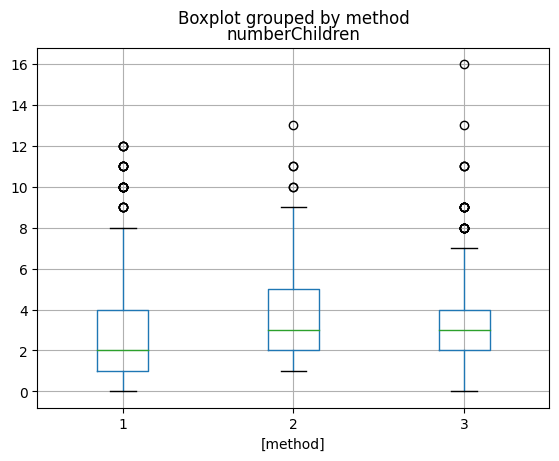

In [37]:
df.boxplot(column=["numberChildren"],by=['method'])

It appear from the box plots and cross tab that couples who choose to use contraception (method=2,3)do have more children on average.

In [38]:
#2
y = df['method'] # Create target variable vector
X = df.drop(["method",df.columns[0]], axis=1)
from sklearn.model_selection import train_test_split
Q3X_train, Q3X_test, Q3y_train, Q3y_test = train_test_split(X,y,test_size=.2,random_state=100)
Q3X_train.head()

,age,edu,edu_spouse,numberChildren,religion,working,spouse_occupation,standardOfLivingIndex,mediaExposure
1227,26,2,4,2,1,1,1,4,0
784,36,4,4,4,1,1,1,4,0
503,28,3,3,3,1,1,1,2,0
614,38,4,4,4,0,1,3,4,0
1059,25,4,4,1,1,1,3,4,0


#3 We are now going to make a mistake. Train a regression tree to predict the contraceptive method using the other variables in the data, not a classification tree. Look at the terminal nodes in the tree: What values do they take? Does that make sense? Explain clearly what has gone wrong here.

(array([34., 35.,  1., 34., 14., 83., 93.,  0.,  0.,  1.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

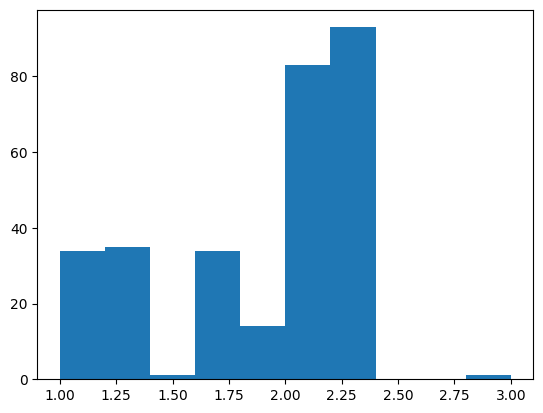

In [39]:
#3
cart = tree.DecisionTreeRegressor(max_depth=5) # Create a classifier object
cart = cart.fit(Q3X_train, Q3y_train) # Fit the classifier
#Make Predictions on the Test Set
y_hat2 = cart.predict(Q3X_test)
plt.hist(y_hat2)


The nodes take decimal values. This does not make sense since it could loosely be interpreted as some sort of likelyhood of that method. For example it is at least clear that 2 is the most likely decision and 3 is the least likely. However, this can not be taken literally. Thus this regression does not actually give much information since it is not treating the decision as categorical and thus predicting in between caes without any meaning. 

#4 Instead of regression, use a classification tree to predict contraceptive method using the other variables in the data. How does it look different from the previous tree? What variables does the algorithm use? In broad terms, which groups of people are most likely to use each method of contraception?

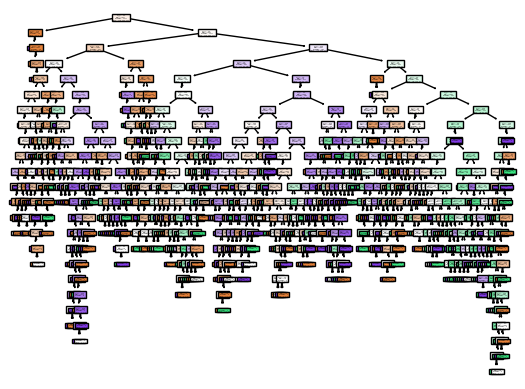

In [40]:
cart = tree.DecisionTreeClassifier() # Create a classifier object
cart = cart.fit(Q3X_train, Q3y_train) # Fit the classifier
#Make Predictions on the Test Set
y_hat2 = cart.predict(Q3X_test)
tree.plot_tree(cart,filled=True)
plt.show()

#https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py
#used this to better see the decisions. Directly from scikit-learn


n_nodes = cart.tree_.node_count
children_left = cart.tree_.children_left
children_right = cart.tree_.children_right
feature = cart.tree_.feature
threshold = cart.tree_.threshold
values = cart.tree_.value
node_indicator = cart.decision_path(Q3X_test)
leaf_id = cart.apply(Q3X_test)
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

print(
    "The binary tree structure has {n} nodes and has "
    "the following tree structure:\n".format(n=n_nodes)
)
for i in range(n_nodes):
    if is_leaves[i]:
        print(
            "{space}node={node} is a leaf node with value={value}.".format(
                space=node_depth[i] * "\t", node=i, value=values[i]
            )
        )
    else:
        print(
            "{space}node={node} is a split node with value={value}: "
            "go to node {left} if X[:, {feature}] <= {threshold} "
            "else to node {right}.".format(
                space=node_depth[i] * "\t",
                node=i,
                left=children_left[i],
                feature=feature[i],
                threshold=threshold[i],
                right=children_right[i],
                value=values[i],
            )
        )

The tree is diffrent in that it does not have terminal nodes with a predictor but rather with bundles that represent the predicted category. The model relies on index 0 (age) and index 3 (number of children) to a signifcant extent. The first split occurs on X[0] <=.5 and then splits on age where younger than 17.5 is using temporary birth control and older is using long term or no brith control. This makes sense since it is likely culturally tradition for a woman to have atleast one child so those that dont may be trying to get pregnant. The second early break is on education, where it splits on 2.5. It then returns to age where everyone except for older lower educated women continue to use temporary birth control. furthermore a far greater percentage of young educated women use long term birth control. Thus overall education,age, and number of children are strong indicators of brith control type used. Specifically older women will use long term or no birth control while younger women will use temporary birth control especially if they have already had a child. 

#5 Compute a confusion matrix for your classification tree on the test set (Hint: There are now three categories instead of two, so the cross tabulation will be a $3 \times 3$ matrix instead of $2 \times 2$.). Compute the Accuracy of your model overall, and the Accuracy for predicting each contraceptive method.

In [51]:
#5
tab =pd.crosstab(Q3y_test,y_hat2)
print("Total count: " +str(Q3y_test.count()))
acc = ((tab.iloc[0,0]+tab.iloc[1,1]+tab.iloc[2,2])/295) # Compute Accuracy
print('Accuracy: ', acc, '\n')

acc1 = (tab.iloc[0,0]/(tab.iloc[0,0]+tab.iloc[1,0]+tab.iloc[2,0])) # Compute Accuracy
acc2 = (tab.iloc[1,1]/(tab.iloc[1,1]+tab.iloc[0,1]+tab.iloc[2,1]))
acc3 = (tab.iloc[2,2]/(tab.iloc[2,2]+tab.iloc[0,2]+tab.iloc[1,2]))
print('Accuracy1: ', acc1, '\n','Accuracy2: ', acc2, '\n','Accuracy3: ', acc3, '\n')
pd.crosstab(Q3y_test,y_hat2)


Total count: 295
Accuracy:  0.4745762711864407 

Accuracy1:  0.5555555555555556 
 Accuracy2:  0.36363636363636365 
 Accuracy3:  0.4235294117647059 



col_0,1,2,3
method,,,
1,80,15,32
2,23,24,17
3,41,27,36


  6. Why can't you use a linear probability model to do this exercise? Explain clearly in words.
 
 You cannot use a linear probability model here because it could not account for the 3 categorical variables. This would be possible if there were only two outcomes becasue the number [0,1] could be seen a probability of outcome 1. However since the three outcomes from this problem have no linear realtionship then a probabilty between them would be impossible to interpret. 
  

**Q4.** This is a question where we use regression and regression trees. The outcome is whether a defendant is held pre-trial in the Virginia justice system. We would like to understand how that outcome is predicted by characteristics of the defendant, particularly race. Let's be very careful/clear: We aren't saying anyone *should* be held without bond or asserting that people with different demographic variables *should* be more likely to be held, but instead trying to predict whether people with different characteristics *are empirically more likely* to be held without bond, given the available information. This is the first step we would take in investigating whether a system is fair, or how large the disparities are: Does it treat people with similar observable characteristics similarly, or not? We are going to look at a common question: Are Black defendants treated differently from white or Asian ones? (There are Native American defendants, but there are 11 in total, which is such a small number of observations that is difficult to clearly say anything about how this group is treated relative to the others.)

The variables in the data are:

  - `held_wo_bail`: Whether a defendant is held without bail before trial (Boolean logical)
  - `race`, `sex`: Categorical demographic variables
  - `is_poor`: Whether the defendant is classified as indigent 
  - `prior_F`, `prior_M`: The number of prior felony and misdemeanor arrests
  - `case_type`: A categorical variable indicating a misdemeanor `M` or felony `F` or infraction `I` or special case `S`
  - `age`: Defendant's age
  - `bond`, `bond_NA`, `bond_type`: The amount of any bond, whether it is missing, and the type
  - `sentence`, `sentence_NA`, `sentence_type`: The length of any sentence, whether it is missing, and the type

1. Load the `pretrial_data.csv` data. Notice that there are `nan`s, but the data are relatively clean. Because there are `.nan`s among variables you won't use, you'll want to narrow down your analysis to the relevant variables before dropping or imputing missing values.
2. Create a dummy variable indicating that the defendant is Black.
3. Regress `held` on `Black`. What is the slope coefficient Interpret the coefficient on the Black dummy variable: How much more likely is a black person to be held without bail? What is the $R^2$ of the model?
4. Before doing this question, please think for a few minutes about how to make the process of running these regressions as efficient as possible, before jumping into writing code. Repeat part 2, for the following specifications, keeping track of the coefficient on the Black dummy variable each time:
      - `held` on `Black` and `sex`
      - `held` on `Black` and `sex` and `is_poor`
      - `held` on `Black` and `sex` and `is_poor` and `prior_F`
      - `held` on `Black` and `sex` and `is_poor` and `prior_F` and `case_type`
What happens to the coefficient on the Black dummy variable as you include more regressors/features/controls in the regression? Explain your findings.
5. Suppose we don't want to see just `Black` and `sex`, but `Black` interacted with `sex`: Are Black men and Black women treated systemically differently from the rest of the population? Implement this in a regression, and explain your findings.
6. Imagine someone argued we should use these kinds of models to help a judge or magistrate make bail decisions (you could obviously go back and make this kind of model for the bond and sentence variables, then deploy it on new cases to predict what their bond and sentence values would be). What concerns would you have? Do you think society should be using data-driven and automated tools like that? Explain your concerns clearly.

**Q5.** This is a math question to review the derivation of the OLS estimator (but only if you are into that kind of thing!). We are going to do it slightly differently from what we did in class, though. We will use a linear predictor and minimize the Sum of Squared Errors, just as in class. But, we are going to de-mean $X$ first, creating another variable $z_i = x_i - \bar{x}$ where 
$$
\bar{x} = \dfrac{1}{N} \sum_{i=1}^N x_i,
$$
so the model is $\hat{y}_i = a + b z_i$ and the `SSE` is
$$
\text{SSE}(a,b) = \sum_{i=1}^N (y_i - a - bz_i)^2.
$$

  1. Take partial derivatives of the `SSE` with respect to $a$ and $b$. You should get

\begin{eqnarray*}
\sum_{i=1}^N -2(y_i - a- bz_i) &=& 0 \\
\sum_{i=1}^N -2(y_i - a - bz_i)z_i &=& 0.
\end{eqnarray*}

  2. Solve for the solutions to the above equations. Big hint: $\bar{z} = 0$, since we subtracted the mean of $x$ from $x$ to get $z$. You should get

\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\sum_{i=1}^N(y_i - \bar{y})z_i}{\sum_{i=1}^N z_i^2}.
\end{eqnarray*}

  3. Substitute $z_i = x_i - \bar{x}$ back into the above equations. You should get
  
\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\sum_{i=1}^N(y_i - \bar{y})(x_i-\bar{x})}{\sum_{i=1}^N (x_i-\bar{x})^2},
\end{eqnarray*}

which can be written in terms of sample covariance and sample variance as:

\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\text{cov}(x,y)}{\text{var}(x)}.
\end{eqnarray*}

This is typically the preferred way of expressing the OLS coefficients.

4. When will $b^*$ be large or small, depending on the relationship between $x$ and $y$ and the amount of "noise"/variance in $x$? What does $a^*$ represent?
5. Suppose you have measurement error in $x$ which artificially inflates its variance (e.g. bad data cleaning). What happens to the $b^*$ coefficient? How will affect your ability to predict? (This phenomenon is called **attenuation**.)
6. Let's return to the question of *outliers*. With your formula for the OLS coefficients $(a^*,b^*)$, explain what happens if you significantly increase a single value of the outcome/target/response variable $y_i$ or one of the predictor/explanatory/covariate variables $x_i$. If values for some extreme observations are exerting significant influence over the regression coefficients, will the model perform well on for more average observations?

In [95]:
! git config --global user.email "mbz8dg@virginia.edu"
!git config --global user.name "mbz8dg"


In [96]:
! git commit -am "Updated work file"

[main 7a60988] Updated work file
 1 file changed, 2013 insertions(+), 10 deletions(-)
